In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
%pylab inline

import os
import random
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import scipy.sparse as sp
from metrics import *
from PIL import Image 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision.transforms as transforms

from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


In [2]:
!nvidia-smi

Wed May 20 13:48:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   29C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:89:00.0 Off |                    0 |
| N/A   28C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [6]:
device = 0

In [4]:
# в этом датасете только интерьерные предметы с картинками наиболее крупных брендов
df = pd.read_csv('Home_and_Kitchen_ratings_core_select.csv')
print(df.shape)
df.head()

/home/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(517858, 14)


,overall,reviewerID,verified,reviewerName,unixReviewTime,reviewText,asin,summary,reviewTime,vote,style,image_x,product_cat,image_y
0,5.0,A8LUWTIPU9CZB,True,Linda Fahner,1446681600,"Great product, love it!!",0560467893,Five Stars,"11 5, 2015",NaN,NaN,NaN,cabinet,['https://images-na.ssl-images-amazon.com/imag...
1,4.0,AN7A2PKJEFL8S,True,MoonMoon,1442016000,There are some people saying they didn't even...,7885124193,Well this is just my experience,"09 12, 2015",NaN,NaN,NaN,cover,['https://images-na.ssl-images-amazon.com/imag...
2,5.0,A3IGCBJJQHPMT4,True,Tianqi Gao,1440028800,my gf likes it,7885124193,Five Stars,"08 20, 2015",NaN,NaN,NaN,cover,['https://images-na.ssl-images-amazon.com/imag...
3,4.0,A1WRVJ56NX95Y1,True,Mike,1437350400,Good price and good product.\nIt's machine was...,7885124193,Good !,"07 20, 2015",NaN,NaN,NaN,cover,['https://images-na.ssl-images-amazon.com/imag...
4,5.0,AU9CFY255RWKO,True,Lori,1429747200,LOVE LOVE LOVE this cute and comfy pillow! The...,7885124193,Rilakkuma rules!,"04 23, 2015",NaN,NaN,NaN,cover,['https://images-na.ssl-images-amazon.com/imag...


In [5]:
ratings_df = df[["reviewerID", "asin", "overall", "unixReviewTime", "product_cat"]]
print(ratings_df.shape)
ratings_df.head(3)

(517858, 5)


,reviewerID,asin,overall,unixReviewTime,product_cat
0,A8LUWTIPU9CZB,0560467893,5.0,1446681600,cabinet
1,AN7A2PKJEFL8S,7885124193,4.0,1442016000,cover
2,A3IGCBJJQHPMT4,7885124193,5.0,1440028800,cover


In [10]:
total_num_of_ratings = len(ratings_df)
print("total number of user-items ratings is:", total_num_of_ratings)

num_of_users = len(ratings_df['reviewerID'].unique())
print("number of unique reviewers is:", num_of_users)

num_of_items = len(ratings_df['asin'].unique())
print("number of unique items is:", num_of_items)

ratings_mean = ratings_df['overall'].mean()
ratings_std = ratings_df['overall'].std()
print("average rating is {:.3f} and standard deviation {:.3f}".format(ratings_mean,ratings_std))

sparsity = float(total_num_of_ratings) / (num_of_users * num_of_items)
print("sparisity of the user-item matrix is", sparsity)

total number of user-items ratings is: 517858
number of unique reviewers is: 174228
number of unique items is: 20277
average rating is 4.336 and standard deviation 1.118
sparisity of the user-item matrix is 0.0001465848332346207


In [11]:
users_df = ratings_df.groupby('reviewerID').size()
print("The average number of items rated by a user is", np.mean(users_df))
print("The average number of items rated by a user is", np.std(users_df))
print("The minimum number of items rated by a user is", min(users_df))
print("The maximum number of items rated by a user is", max(users_df))

The average number of items rated by a user is 2.9723006634984044
The average number of items rated by a user is 1.6487030229363329
The minimum number of items rated by a user is 2
The maximum number of items rated by a user is 80


In [12]:
items_df = ratings_df.groupby('asin').size()
print("The average number of users that rated an item is", np.mean(items_df))
print("The standard deviation of number of users that rated an item is", np.std(items_df))
print("The minimum number of users that rated an item is", min(items_df))
print("The maximum number of users that rated an item is", max(items_df))

The average number of users that rated an item is 25.539182324801498
The standard deviation of number of users that rated an item is 69.13462444582329
The minimum number of users that rated an item is 1
The maximum number of users that rated an item is 2162


In [13]:
df_meta = pd.read_csv("df_meta_imgs.csv")
df_meta = df_meta.drop_duplicates(["asin"])
print(df_meta.shape)
df_meta.head()

(638049, 18)


,category,description,title,also_buy,brand,rank,also_view,main_cat,similar_item,date,price,asin,feature,image,tech1,details,fit,tech2
0,"['Home & Kitchen', 'Bath', 'Bathroom Accessori...",['The only soap in the world with a unique com...,4 BARS! Mysore Sandal Soap 70grams FAST SHIPPING,NaN,Mysore,">#6,942,841 in Home & Kitchen (See Top 100 in ...",['B001G7PZB0'],Amazon Home,NaN,NaN,$22.00,0009046461,NaN,['https://images-na.ssl-images-amazon.com/imag...,NaN,NaN,NaN,NaN
1,"['Home & Kitchen', 'Wall Art', 'Posters & Prin...",['Shiver me timbers! Solve I SPY pirate pictur...,Scholastic Pirate's Treasure Fundle,['0439900581'],Scholastic,"6,129inSoftware(","['0439042445', '0545415837', '0439763096', '05...",Software,NaN,NaN,$2.59,0439903491,['Software: Play I SPY games to uncover the hi...,['https://images-na.ssl-images-amazon.com/imag...,NaN,NaN,NaN,NaN
2,"['Home & Kitchen', 'Bedding', ""Kids' Bedding"",...",['100% official merchandiseReversible - 2 desi...,My Little Pony Equestria Single/US TWin Duvet ...,"['B00I8TCB02', 'B00K5B0PCC', 'B00P8BOYNU', 'B0...",My Little Pony,">#1,401,081 in Home & Kitchen (See Top 100 in ...","['B072F37S7R', 'B01GJ90UWI']",Amazon Home,NaN,NaN,NaN,0456680012,"['100% official merchandise', 'Features Rainbo...",['https://images-na.ssl-images-amazon.com/imag...,NaN,NaN,NaN,NaN
3,"['Home & Kitchen', 'Kitchen & Dining', 'Storag...","['Not so high deluxe qualify, but really good ...","Insulated Lunch Bag, Lunchbox, Bento Box (Pack...",NaN,KINGREE,">#1,198,876 in Kitchen & Dining (See Top 100 i...",NaN,Amazon Home,NaN,"January 1, 2015",NaN,0555667502,"['Size: Big bag 8.7""L x 5.7""H x 5.8""W Zipper C...",['https://images-na.ssl-images-amazon.com/imag...,NaN,NaN,NaN,NaN
4,"['Home & Kitchen', 'Home Dcor', 'Home Dcor Acc...",['Chicago Floating Shelf is an impressively se...,"WELLAND Chicago Wall Floating Corner Shelf, 20...",NaN,WELLAND,">#1,037,069 in Home & Kitchen (See Top 100 in ...","['B01MU19YA0', 'B076H9JBS7', 'B06XT37BDF', 'B0...",Amazon Home,NaN,NaN,NaN,0560467893,['Dimensions: 20-inch W by 20-inch D by 1.75-i...,['https://images-na.ssl-images-amazon.com/imag...,NaN,NaN,NaN,NaN


In [14]:
df = df.merge(df_meta[["asin", "brand"]], left_on="asin", right_on="asin")
print(df.shape)
df.head()

(517858, 15)


,overall,reviewerID,verified,reviewerName,unixReviewTime,reviewText,asin,summary,reviewTime,vote,style,image_x,product_cat,image_y,brand
0,5.0,A8LUWTIPU9CZB,True,Linda Fahner,1446681600,"Great product, love it!!",0560467893,Five Stars,"11 5, 2015",NaN,NaN,NaN,cabinet,['https://images-na.ssl-images-amazon.com/imag...,WELLAND
1,5.0,A11363TB6A4YQ3,True,Matthew K. Smyj,1467849600,"Sturdy, attractive, and easy to mount. Corner ...",0560467893,Five Stars,"07 7, 2016",NaN,NaN,NaN,cabinet,['https://images-na.ssl-images-amazon.com/imag...,WELLAND
2,5.0,A18GCSCVCOAK7G,True,Cyndy,1462492800,Love this product. I purchased this for my wi...,0560467893,Great for my wireless printer.,"05 6, 2016",NaN,NaN,NaN,cabinet,['https://images-na.ssl-images-amazon.com/imag...,WELLAND
3,5.0,A3Q1KB5XCD0M4V,True,tootz,1459209600,Is a nice size shelf,0560467893,Like It,"03 29, 2016",NaN,NaN,NaN,cabinet,['https://images-na.ssl-images-amazon.com/imag...,WELLAND
4,4.0,AN7A2PKJEFL8S,True,MoonMoon,1442016000,There are some people saying they didn't even...,7885124193,Well this is just my experience,"09 12, 2015",NaN,NaN,NaN,cover,['https://images-na.ssl-images-amazon.com/imag...,Rilakkuma


In [15]:
brands_to_use = [
    "Safavieh", # 1 or white-all
    "Sauder", # 1 (first)
    "Flash Furniture", # 1 (emblems!)
    "South Shore", # 1 (instructions!)
    "Coaster Home Furnishings", # 1
    "Signature Design by Ashley", # 1
    "Baxton Studio", # 1
    "Convenience Concepts", # 1 or white-all
    "Home Styles", # 1 or white-all
    "Monarch Specialties", # 1 or white-3 (instructions!)
    "Modway", # 1 or white-2
    "nuLOOM", # 1 or white-2
    "Prepac", # 1 or white-2
    "Ottomanson", # 1 or white-2
    "Madison Park", # 1
    "Winsome Wood", # 1
    "DHP", # 1 or white-4
#     "Sunbeam",
    "Furinno", # 1
    "Winsome", # 1
    "Maxy Home", # 1
#     "Disney",
    "Simpli Home", # 1
    "Best Home Fashion", # 1
    "Well Woven", # 1 or white-2
    "AS Quality Rugs", # 1 or white-2
    "Linon", # 1
    "Furniture of America", # 1 or white-all
    "Unique Loom", # 1
    "Ameriwood Home", # 1 or white-2
    "Superior", # 1
    "Great Deal Furniture", # 1
    "International Concepts", # 1
    "HOMCOM", # 1
    "Home Dynamix", # 1 or white-3
    "Homelegance", # 1
    "LIFE Home", # 1
    "Leick Furniture", # 1
    "Kings Brand Furniture", # 1 or white-3
#     "Collections Etc",
    "RugStylesOnline", # 1 or white-2
    "Wieco Art", # 1
    "Bush Furniture", # 1
    "LINKWELL", # 1
#     "Pinzon by Amazon", # 1 ? 
    "Deco 79", # 1 or white-3
    "Style Master", # 1
    "CaliTime", # 1
    "Deconovo", # 1
    "Universal Rugs", # 1
#     "IKEA", #
#     "KidKraft"
    "MyGift", # 1
    "HOMES: Inside + Out", # 1
    "ORIENTAL FURNITURE", # 1
#     "Merax" # ?
#     "Persian Area Rugs" ?
#     "King's Brand" ?
#     "Ellis Curtain",
    "Eclipse", # 1 (!)
    "Dorel Living", # 1 or white-2
#     "HOSL" 
    "Royal Hotel", # 1 or white-2 (?)
    "Mohawk Home", # 1
#     "Fashion Bed Group",
#     "Serta",
    "Chezmoi Collection", # 1
    "Elegant Comfort", # 1 or white-2 (?)
    "Rugshop", # 1 or white-2
#     "decorbox",
#     "Zinus", ?
    "House, Home and More", # 1
#     "Garland Rug", 
    "Boss Office Products", # 1
    "Infinity Instruments", # 1
    "Tache Home Fashion", # 1 or white-2
    "Lush Decor", # 1 or 2
    "Target Marketing Systems", # 1
#     "Lorraine Home Fashions",
#     "Generic",
    "Office Star", # 1
    "HON", # 1
    "Home Decorators Collection", # 1
    "Frenchi Home Furnishing", # 1
    "Surefit", # 1
    "Roundhill Furniture", # 1
    "Hosley", # 1
    "Heritage Lace", # 1
    "simplehuman", # 1
#     "Best-selling",                       мусор
    "Kiera Grace", # 1? рамки с фотками
    "Lavish Home", # 1 or white-2
    "Poundex", # 1 ?
    "United Curtain", # 1
    "Home Soft Things", # 1
    "Southern Enterprises", # 1 or white-3
    "Adeco", # 1? рамки
#     "Generations",                        мусор
    "East West Furniture", # 1 or 2
    "Walker Edison Furniture Company", # 1 or white-2
#     "InterDesign", # 1? food on everyphoto
    "HIPPIH", # 1
    "Sun Zero", # 1?
#     "BEST CHOICE PRODUCTS"               spam
    "Hillsdale Furniture", # 1
    "Achim Home Furnishings", # 1#
    "Window Elements", # 1-2
    "No. 918", # 1#
    "Howard Miller", # 1
    "HPD Half Price Drapes", # 1#
#     "Feraghan/New City", # ?
    "Exclusive Home Curtains", # 1#
#     "Ode-Rin", #  мусор
    "Fab Habitat", # 1
#     "Ambesonne"                          мусор
    "Greenland Home", # 1 or white-4
#     "Jay Franco", #             spam
    "OFM", # 1
    "JinStyles", # 1
    "Delta Children", # 1
    "Clara Clark", # 1-4
    "VHC Brands", # 1-3
    "Nourison", #1-3
    "Nexera", #1
    "Fab Glass and Mirror", #1
    "Crosley Furniture", #1-2
    "Elegant Home Fashions", #1
    "Ojia", #1
#     "JustNile", #spam
    "Sweet Jojo Designs", #1
    "Boraam", #1
    "Atlantic Furniture", #1
    "Fancy Linen", #1
    "eHomeProducts", #2
    "Web Linens Inc", #1-2
#     "Giantex", #spam
    "GoodGram", #1
    "Roundhill", #1
    "Utopia Bedding", #1
    "Skyline Furniture", #1
    "SONGMICS", #1
    "puredown", #1
    "La Crosse Technology", #1
    "Loloi", #4
#     "Mainstay", #spam
    "Big Joe", #1-2
    "Andreannie", #2
    "Persian-Rugs", #1-2
    "Divano Roma Furniture", #1-3
#     "ChezMax", #spam
    "Tvilum", #1
    "Techni Mobili", #1
#     "Household Essentials", #spam
    "Royal Imports", #1
    "Cotton Craft", #1
    "WE Furniture", #1-4
    "Kapaqua", #1-6
    "Alera", #1
    "Casual Home", #1-3
#     "Atlantic", #spam
    "Altra Furniture", #1
#     "TrendSetter Homez", #spam
    "NICETOWN", #1-2
    "Vaulia", #1-7
    "Biddeford", #1
#     "MALOUF", #spam
    "Bedford Home", #1-4
#     "Bounce Comfort", #spam
    "Cosco", #1-2
    "Home Source Industries", #1
    "NaturalAreaRugs", #1-2
    "Sonax", #1-2
    "Koeckritz", #1
    "WELLAND", #1
    "Grand Linen", #1
    "DII", #1
    "USTIDE", #1
    "Danya B", #1
    "Queenie Wong", #1
    "Southern Enterprises, Inc.", #1
    "247SHOPATHOME", #1-4
    "Pillowcase", #1
    "ABeadedCurtain", #1
#     "Unknown", #spam
    "Safco Products", #1
]
df.loc[df.brand.isin(brands_to_use)].shape, df.loc[df.brand.isin(brands_to_use)].asin.unique().size

((252182, 15), 8294)

In [16]:
asin_to_use = set(df.loc[df.brand.isin(brands_to_use)].asin.unique().tolist())
len(asin_to_use)

8294

In [9]:
# import pickle

# with open('./asin_to_use_main.pickle', 'wb') as handle:
#     pickle.dump(asin_to_use, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
# subselect dataset of reviews to asins we are interested in
ratings_df = ratings_df.loc[ratings_df.asin.isin(asin_to_use)]#.copy()#.loc[ratings_df.reviewerID.isin(users_core)]
print(ratings_df.shape)

users_ratings_df = ratings_df.reviewerID.value_counts()
display(users_ratings_df.value_counts()[:10]) # сколько людей купили 1 - 10 товаров (дальше меньше, очевидно)
display(users_ratings_df.value_counts()[::-1].cumsum()[-10:])

(252182, 5)


1     56481
2     47271
3     16371
4      6225
5      2249
6      1062
7       493
8       244
9       160
10       89
Name: reviewerID, dtype: int64

10       220
9        380
8        624
7       1117
6       2179
5       4428
4      10653
3      27024
2      74295
1     130776
Name: reviewerID, dtype: int64

In [18]:
# допустим, теперь мы хотим отобрать только тех, кто купил не менее 2 (3?) товаров
users_subset = users_ratings_df[users_ratings_df >= 2].index.tolist()
ratings_df = ratings_df.loc[ratings_df.reviewerID.isin(users_subset)]
ratings_df.shape

(195701, 5)

In [19]:
total_num_of_ratings = len(ratings_df)
print("total number of user-items ratings is:", total_num_of_ratings)

num_of_users = len(ratings_df['reviewerID'].unique())
print("number of unique reviewers is:", num_of_users)

num_of_items = len(ratings_df['asin'].unique())
print("number of unique items is:", num_of_items)

ratings_mean = ratings_df['overall'].mean()
ratings_std = ratings_df['overall'].std()
print("average rating is {:.3f} and standard deviation {:.3f}".format(ratings_mean,ratings_std))

sparsity = float(total_num_of_ratings) / (num_of_users * num_of_items)
print("sparisity of the user-item matrix is", sparsity)

total number of user-items ratings is: 195701
number of unique reviewers is: 74295
number of unique items is: 8245
average rating is 4.333 and standard deviation 1.105
sparisity of the user-item matrix is 0.00031947935416035865


In [20]:
users_df = ratings_df.groupby('reviewerID').size()
print("The average number of items rated by a user is", np.mean(users_df))
print("The standard deviation number of items rated by a user is", np.std(users_df))
print("The minimum number of items rated by a user is", min(users_df))
print("The maximum number of items rated by a user is", max(users_df))

The average number of items rated by a user is 2.634107275052157
The standard deviation number of items rated by a user is 1.1796760872542351
The minimum number of items rated by a user is 2
The maximum number of items rated by a user is 35


In [21]:
items_df = ratings_df.groupby('asin').size()
print("The average number of users that rated an item is", np.mean(items_df))
print("The standard deviation of number of users that rated an item is", np.std(items_df))
print("The minimum number of users that rated an item is", min(items_df))
print("The maximum number of users that rated an item is", max(items_df))

The average number of users that rated an item is 23.735718617343846
The standard deviation of number of users that rated an item is 69.44857670719108
The minimum number of users that rated an item is 1
The maximum number of users that rated an item is 1862


In [22]:
# - отсортируем рейтингс_кор по времени
ratings_df = ratings_df.sort_values("unixReviewTime")

# - возьмем людей, которые купили 5+ интересующих нас товаров
users_test = users_ratings_df[users_ratings_df >= 5].index.tolist()
len(users_test)

4428

In [23]:
def get_last_20_per(x):
    n = len(x) // 5
    return x[-n:]

In [24]:
# - положим в тест 20% товаров, которые они купили последними
idx_test = ratings_df[ratings_df.reviewerID.isin(users_test)].reset_index().groupby("reviewerID").index.apply(get_last_20_per).tolist()

ratings_train = ratings_df.loc[~ratings_df.index.isin(idx_test)]
ratings_test = ratings_df.loc[ratings_df.index.isin(idx_test)]
ratings_train.shape, ratings_test.shape

((191007, 5), (4694, 5))

In [25]:
# neg_test.to_csv("neg_test_Core-5-Large-BrandsNewTest.csv", index=True)
neg_test = pd.read_csv("neg_test_Core-5-Large-BrandsNewTest.csv", index_col=0)
neg_test.head(5)

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
70595,B00CIXNYDC,B01DKS3OOM,B00HQ2XTYO,B002PIHIKU,B017R2BPKW,B00MFYESLQ,B00FAVF7NO,B003XSSHME,B01DVC1BH4,B006IY94WM,...,B017YQM9YW,B002KA7RCM,B00ASU0L0G,B01GQFRVNQ,B006OMZ5GC,B010V2735Q,B00006IBB3,B00HJGC7GS,B00S6TUQUQ,B018098TWS
29529,B00FF4WXEW,B00G9XGVV4,B00IMDXQRG,B01BIAF7I0,B01CIRCGFY,B00BTYQXAC,B013X012GO,B004LQ1UP8,B004Z2WWWS,B00PVQ44KA,...,B000K2NXAM,B00RRE13TO,B01GVOW3GC,B00PKQT49W,B016QUILIA,B00HS3J2SI,B00N75XVEW,B00LUACBYC,B0173I5MKY,B00EP05ECA
70550,B002QYX4WY,B0029LHTGQ,B00LFM8CSY,B00JYBS3RS,B00H8I4D64,B00IA8OELK,B004M40PJQ,B00U256FXY,B001G0NNS4,B001FB5K8A,...,B0039MIMYC,B0061NMDA0,B001VNS822,B000J355TO,B00562XZ7W,B00P04MPJ0,B003RWTNB0,B00H5OXAXI,B007UQ6LF0,B00GZ17HKO
46898,B009YIQWAG,B004YMWEJU,B00TMATPP0,B00QUEFZPU,B01G2ELLGY,B00FKIPBII,B0015DMV76,B003ZSH9BM,B01CI5V0TE,B00ULHQ80I,...,B00TH7XNYC,B004HM37OS,B00FNV8968,B00QUB7FHO,B00TS64IPU,B00DY2LPSC,B00MUYNPSI,B00NBC1HCO,B0072VZ5IW,B004HGEDUQ
34588,B005H6T9WM,B004SI9KAG,B00FHVUM0K,B0091QTBYK,B003ZXFHZW,B010FKZUS6,B0091T3UR6,B004L2L304,B00EQ1TP32,B00GXGY58I,...,B00GD9PF0M,B00JTRJT5W,B00PXVWKGS,B00WO52E8A,B000OJNT6Y,B012SK7WL4,B0095G008M,B0083VHH36,B01C4N9OUC,B005EGNIZ4


In [26]:
# заменим айди числами 
user_enc = LabelEncoder()
user_enc.fit(ratings_df.reviewerID)
ratings_train.reviewerID = user_enc.transform(ratings_train.reviewerID)
ratings_test.reviewerID = user_enc.transform(ratings_test.reviewerID)
user_num = user_enc.classes_.size

item_enc = LabelEncoder()
item_enc.fit(ratings_df.asin)
ratings_train.asin = item_enc.transform(ratings_train.asin)
ratings_test.asin = item_enc.transform(ratings_test.asin)
item_num = item_enc.classes_.size

/home/.local/lib/python3.5/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [27]:
# neg_test = np.stack(neg_test)
neg_test = item_enc.transform(neg_test.values.ravel()).reshape(neg_test.shape)
neg_test = pd.DataFrame(neg_test, index=ratings_test.index)
neg_test.head()

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
70595,3481,7786,4545,1033,7290,5300,4041,1329,7814,2331,...,7312,996,3159,8101,2338,6694,5,4530,6035,7319
29529,4075,4292,4688,7636,7703,3381,6869,1634,1779,5781,...,136,6004,8149,5718,7194,4551,5411,5238,7236,3899
70550,1044,874,5162,4896,4483,4627,1647,6231,599,572,...,1162,2210,805,126,1918,5642,1279,4464,2565,4419
46898,3028,1766,6151,5902,8041,4122,377,1354,7701,6295,...,6128,1565,4170,5879,6174,3740,5365,5416,2415,1560
34588,2050,1692,4091,2826,1359,6656,2829,1616,3912,4406,...,4309,4877,5790,6442,194,6794,2876,2616,7682,1980


In [28]:
# сколько получилось всего юзеров и товаров?
ratings_df.reviewerID.value_counts().size, ratings_df.asin.value_counts().size

(74295, 8245)

In [29]:
# Each Line is a training instance: 
# userID   itemID   rating   timestamp (if have)
ratings_train.head()

,reviewerID,asin,overall,unixReviewTime,product_cat
15621,17866,161,5.0,1048291200,dining_table
58720,73444,430,2.0,1095292800,table
70313,73444,686,2.0,1095292800,cabinet
604,45750,15,1.0,1100476800,clock
1904,45750,26,1.0,1100476800,clock


In [30]:
# Each Line is a testing instance: 
# userID   itemID   rating   timestamp (if have)
ratings_test.head()

,reviewerID,asin,overall,unixReviewTime,product_cat
70595,73479,686,1.0,1217894400,cabinet
29529,12240,304,1.0,1231113600,cabinet
70550,51314,681,1.0,1243296000,interior_other
46898,8727,304,5.0,1277856000,cabinet
34588,31854,368,5.0,1282694400,cabinet


In [31]:
ratings_test.product_cat.value_counts()

rug               988
cabinet           807
dining_table      764
curtain           521
cover             457
chair             410
couch             232
interior_other    185
trashcan           81
table              77
clock              61
plant_pot          52
rack               23
paint              14
mirror             13
bean_bag            9
Name: product_cat, dtype: int64

In [99]:
import os
import random
from PIL import Image 

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class AmazonImgs(data.Dataset):
    """
    Arguments:
        path: path to data folder
    """
    
    def __init__(self, dir_path, transform=None, mode="sample", asin_to_use=set()):
        self.asin = [] # list of asins
        self.imgs = {} # dict {asin : [asin images]}
        self.transform = transform
        self.mode = mode
        self.asin_to_use = asin_to_use
        
        # obj = asin
        for obj in tqdm(os.listdir(dir_path)):
            if not self.asin_to_use or obj in self.asin_to_use:
                self.asin.append(obj)
                obj_path = os.path.join(dir_path, obj)
                # save the list of imgs for asin
                obj_imgs = []
                for img in os.listdir(obj_path):
                    img_path = os.path.join(dir_path, obj, img)
                    img = pil_loader(img_path)
                    obj_imgs.append(img)
                self.imgs[obj] = obj_imgs
            
    def get_asin_imgs(self, asin):
        # here we return all images for this asin
        return [self.transform(img) for img in self.imgs[asin]]
        
    def sample_asin_img(self, asin):
        # here we sample a random image from images for this asin
        img = random.sample(self.imgs[asin], 1)[0]
        return self.transform(img)
         
    def __getitem__(self, index):
        asin = self.asin[index]
        if self.mode == "sample":
            return self.sample_asin_img(asin)
        if self.mode == "all":
            return self.get_asin_imgs(asin)
        
    def __len__(self):
        return len(self.asin)

In [100]:
input_size = 224
transform=transforms.Compose([
                            transforms.CenterCrop(input_size),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ])

amazon_imgs = AmazonImgs(dir_path="NewCatinki/", transform=transform, mode="sample", asin_to_use=asin_to_use)
len(amazon_imgs)

100%|██████████| 20293/20293 [02:10<00:00, 155.78it/s]


8294

In [32]:
def hit(gt_item, pred_items):
    if gt_item in pred_items:
        return 1
    return 0

def ndcg(gt_item, pred_items):
    if gt_item in pred_items:
        index = pred_items.index(gt_item)
        return np.reciprocal(np.log2(index+2))
    return 0


def evaluate(model, test_loader, top_k):
    HR = {k : [] for k in top_k}
    for user, item, item_ft, label in tqdm(test_loader):
        user = user.long().to(device)
        item = item.long().to(device)
        item_ft = item_ft.float().to(device)

        predictions = model(user, item, item_ft)
        _, indices = torch.topk(predictions, top_k[-1])
        recommends = torch.take(item, indices).cpu().numpy().tolist()

        gt_item = item[0].item()
        for k in top_k:
            HR[k].append(hit(gt_item, recommends[:k]))

    return {k : np.mean(HR[k]) for k in top_k}

In [33]:
def prepare_data(ratings_train, ratings_test, neg_test):
    train_data = ratings_train[["reviewerID", "asin"]].values.tolist()
    train_mat = sp.dok_matrix((user_num, item_num), dtype=np.float32)
    for x in tqdm(train_data):
        train_mat[x[0], x[1]] = 1.0
        
    test_data = []
    # тут мы создаем (или используем готовые) негатив сэмплы для теста
    for ix in tqdm(ratings_test.index):
        u, i = ratings_test.loc[ix, ["reviewerID", "asin"]].values.tolist()
        test_data.append([u, i])
        test_data += [[u, ni] for ni in neg_test.loc[ix].values.tolist()]
            
    return train_data, test_data, train_mat

In [34]:
# dataset returns
# (user, item, item_features, label) set
# but item_features can used or ignored depending on the model
class NCFData(data.Dataset):
    def __init__(self, features, num_item, 
                 train_mat=None, num_ng=0, is_training=None,
                 item_features=None):
        super(NCFData, self).__init__()
        """ Note that the labels are only useful when training, we thus 
            add them in the ng_sample() function.
        """
        self.features_ps = features
        self.num_item = num_item
        self.train_mat = train_mat
        self.num_ng = num_ng
        self.is_training = is_training
        self.item_features = item_features
        self.labels = [0 for _ in range(len(features))]

    def ng_sample(self):
        assert self.is_training, 'no need to sampling when testing'

        self.features_ng = []
        for x in self.features_ps:
            u = x[0]
            for t in range(self.num_ng):
                j = np.random.randint(self.num_item)
                # генерим рандомные итемы для этого юзера, 
                # пока не получим ту, которой нет в трейне
                while (u, j) in self.train_mat:
                    j = np.random.randint(self.num_item)
                self.features_ng.append([u, j])

        labels_ps = [1 for _ in range(len(self.features_ps))]
        labels_ng = [0 for _ in range(len(self.features_ng))]

        self.features_fill = self.features_ps + self.features_ng
        self.labels_fill = labels_ps + labels_ng

    def __len__(self):
        return (self.num_ng + 1) * len(self.labels)

    def __getitem__(self, idx):
        features = self.features_fill if self.is_training \
                    else self.features_ps
        labels = self.labels_fill if self.is_training \
                    else self.labels

        user = features[idx][0]
        item = features[idx][1]
        item_ft = self.item_features[item] # тут скорее всего нампи массив
        label = labels[idx]
        return user, item, item_ft, label

In [35]:
# create item_features dict

# ! default item_features are
# one-hot-encoded product_cats of the item

# but it can be (added or replacing)
# embeddings from various models obtained from the images

# ! it also can be raw images, if we would like to fine-tune
# the feature extraction model during the NCF training

items = ratings_df[["asin", "product_cat"]].drop_duplicates()
items["asin"] = item_enc.transform(items["asin"])
items = items.set_index("asin")
items = pd.get_dummies(items["product_cat"])

In [64]:
item_features = {}
for ix in items.index:
    item_features[ix] = np.float32(items.loc[ix].values)
len(item_features)

8245

In [37]:
general_args = {
    # model
    "user_num" : user_num,
    "item_num" : item_num,
    "GMF_embedding_size" : 32,
    "MLP_embedding_size" : 128,
    "MLP_layers" : [128, 64, 8],
    "context_mode" : None, 
    "dropout" : 0,
    "item_features_size" : len(item_features[0]),
    "item_preembed_size" : None,
    "mode" : "NeuMF-end",
    # training
    "n_epochs" : 20,
    "batch_size" : 1000,
    "lr" : 3e-5,
    #
    "top_k" : [1, 5, 10, 30], # k for metric@top_k
    "num_ng" : 4, # fixed
    "test_num_ng" : 99, # fixed
}

In [43]:
args = {k : v for k, v in general_args.items()}

In [65]:
train_data, test_data, train_mat = prepare_data(ratings_train, ratings_test, neg_test)
# construct the train and test datasets
train_dataset = NCFData(train_data, item_num, train_mat, args["num_ng"], True, item_features)
test_dataset = NCFData(test_data, item_num, train_mat, 0, False, item_features)

100%|██████████| 4694/4694 [00:10<00:00, 462.64it/s]


In [66]:
# test sampling
train_dataset.ng_sample()
train_dataset[0] # user, item, label

(17866,
 161,
 array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 1)

In [67]:
train_loader = data.DataLoader(train_dataset, batch_size=args["batch_size"], shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=args["test_num_ng"] + 1, shuffle=False)

In [ ]:
# now we define NCF models we will use
# 1) the one that only uses user-item matrix (& learns embeddgins)
# 2) the one that uses user-item matrix + context info for items 
# 3) the one that uses context info for items to replace item embeddings
# and only learns embeddigns for users
# 4) probably we should use a model that can fine-tune the embedding model
# along with collaborative filteration

In [68]:
class NCF(nn.Module):
    def __init__(self, 
                 user_num, # number of users
                 item_num, # number of items
                 GMF_embedding_size,
                 MLP_embedding_size,
                 item_features_size, # item_features vector size
                 item_preembed_size=None,
                 MLP_layers=[128, 64, 8],
                 dropout=0, # dropout
                 context_mode="none", # "add", "replaced"
                 mode="NeuMF-end", # 'MLP', 'GMF', 'NeuMF-end', and 'NeuMF-pre'
                 GMF_model=None, MLP_model=None):
        super(NCF, self).__init__()
        """
        user_num: number of users;
        item_num: number of items;

        dropout: dropout rate between fully connected layers;
        mode: 'MLP', 'GMF', 'NeuMF-end', and 'NeuMF-pre';
        GMF_model: pre-trained GMF weights;
        MLP_model: pre-trained MLP weights.
        """	
        self.dropout = dropout
        self.context_mode = context_mode
        self.mode = mode
        self.GMF_model = GMF_model
        self.MLP_model = MLP_model
        
        item_preembed_size = item_features_size if item_preembed_size is None else item_preembed_size
        
        # what we have to do here
        
        # 1. we have 2 models, GMF and MLP
        # GMF has totally simple structure - just 2 embeddgins (& probably item features)
        # but embeddings should be of the same size
        # MLP - more complex, we stack embeddings 
        # and process them with multilayer model
        
        # we need mlp model architecture
        # (list of layer sizes)
        
        # and a strategy how to deal with the context features
        # 1) drop
        # 2) ? stack with item pre-embedding & map to general embedding size
        # in this case item pre-embedding size can be defined (e.g smaller than user embedding size)
        # 3) map to corresponding item embeddings size and use instead

        # GMF
        self.embed_user_GMF = nn.Embedding(user_num, GMF_embedding_size)
        if self.context_mode == "none":
            self.embed_item_GMF = nn.Embedding(item_num, GMF_embedding_size)
        elif self.context_mode == "add":
            self.embed_item_GMF = nn.Embedding(item_num, item_preembed_size)
            self.join_item_features_GMF = nn.Sequential(
                nn.Linear(item_preembed_size + item_features_size, GMF_embedding_size),
            )
        elif self.context_mode == "replace":
            self.item_features_GMF = nn.Sequential(
                nn.Linear(item_features_size, GMF_embedding_size),
            )
        
        # MLP
        self.embed_user_MLP = nn.Embedding(user_num, MLP_embedding_size)
        if self.context_mode == "none":
            self.embed_item_MLP = nn.Embedding(item_num, MLP_embedding_size)
        elif self.context_mode == "add":
            self.embed_item_MLP = nn.Embedding(item_num, item_preembed_size)
            self.join_item_features_MLP = nn.Sequential(
                nn.Linear(item_preembed_size + item_features_size, MLP_embedding_size),
            )
        elif self.context_mode == "replace":
            self.item_features_MLP = nn.Sequential(
                nn.Linear(item_features_size, MLP_embedding_size),
            )
        
        
        self.MLP_layers = []
        n_in_units = [MLP_embedding_size * 2] + MLP_layers[:-1]
        n_out_units = MLP_layers
        for n_in, n_out in zip(n_in_units, n_out_units):
            self.MLP_layers += [
                nn.Dropout(p=self.dropout),
                nn.Linear(n_in, n_out),
                nn.BatchNorm1d(n_out),
                nn.ReLU(inplace=True),
            ]
        self.MLP_layers = nn.Sequential(*self.MLP_layers)

        if self.mode == 'GMF':
            predict_size = GMF_embedding_size
        elif self.mode == 'MLP':
            predict_size = MLP_layers[-1]
        else:
            predict_size = GMF_embedding_size + MLP_layers[-1]
        self.predict_layer = nn.Linear(predict_size, 1)

    # here we could add sopisticated initialization for weights
    # and/or usage of the pretrained weights - but for now just use defaults

    def forward(self, user, item, item_ft):
        # GMF
        if not self.mode == 'MLP':
            embed_user_GMF = self.embed_user_GMF(user)
            if self.context_mode == "none":
                embed_item_GMF = self.embed_item_GMF(item)
            elif self.context_mode == "add":
                embed_item_GMF = self.embed_item_GMF(item)
                embed_item_GMF = torch.cat((embed_item_GMF, item_ft), dim=-1) # join one embedding with another and process
                embed_item_GMF = self.join_item_features_GMF(embed_item_GMF)
            elif self.context_mode == "replace":
                embed_item_GMF = self.item_features_GMF(item_ft)
            output_GMF = embed_user_GMF * embed_item_GMF
            
        # MLP
        if not self.mode == 'GMF':
            embed_user_MLP = self.embed_user_MLP(user)
            if self.context_mode == "none":
                embed_item_MLP = self.embed_item_MLP(item)
            elif self.context_mode == "add":
                embed_item_MLP = self.embed_item_MLP(item)
                embed_item_MLP = torch.cat((embed_item_MLP, item_ft), dim=-1) # join one embedding with another and process
                embed_item_MLP = self.join_item_features_MLP(embed_item_MLP)
            elif self.context_mode == "replace":
                embed_item_MLP = self.item_features_MLP(item_ft)            
            interaction = torch.cat((embed_user_MLP, embed_item_MLP), -1)
            output_MLP = self.MLP_layers(interaction)

        # output & predict
        if self.mode == 'GMF':
            concat = output_GMF
        elif self.mode == 'MLP':
            concat = output_MLP
        else:
            concat = torch.cat((output_GMF, output_MLP), -1)

        prediction = self.predict_layer(concat)
        return prediction.view(-1)

In [ ]:
# # [TODO] !
# # and here we still need the model testing function
# # (for asins prediction & their images plotting)

# def generate_recommends(model, user, asin_imgs_dataset,
#                        user_ratings=ratings_test, user_negs=neg_test)

In [ ]:
#  now we conduct the experiments

In [ ]:
# 1) USER-ITEM matrix

In [69]:
# USER-ITEM matrix
args = {k : v for k, v in general_args.items()}
args.update({
    # training
    "n_epochs" : 50,
    "batch_size" : 1000,
    "lr" : 5e-5,
    # model
    "GMF_embedding_size" : 32,
    "MLP_embedding_size" : 128,
    "MLP_layers" : [128, 64, 32],
    "context_mode" : "none", 
    "dropout" : 0,
    "item_features_size" : len(item_features[0]),
    "item_preembed_size" : None,
    "mode" : "NeuMF-end",
})

model = NCF(args["user_num"], 
            args["item_num"], 
            args["GMF_embedding_size"], 
            args["MLP_embedding_size"], 
            args["item_features_size"], 
            args["item_preembed_size"], 
            args["MLP_layers"], 
            args["dropout"], 
            args["context_mode"],
            args["mode"], 
            GMF_model=None, MLP_model=None)
model.to(device)
loss_function = nn.BCEWithLogitsLoss()

if args["mode"] == 'NeuMF-pre':
    opt = torch.optim.SGD(model.parameters(), lr=args["lr"])
else:
    opt = torch.optim.Adam(model.parameters(), lr=args["lr"])

In [70]:
args

{'GMF_embedding_size': 32,
 'MLP_embedding_size': 128,
 'MLP_layers': [128, 64, 32],
 'batch_size': 1000,
 'context_mode': 'none',
 'dropout': 0,
 'item_features_size': 16,
 'item_num': 8245,
 'item_preembed_size': None,
 'lr': 5e-05,
 'mode': 'NeuMF-end',
 'n_epochs': 50,
 'num_ng': 4,
 'test_num_ng': 99,
 'top_k': [1, 5, 10, 30],
 'user_num': 74295}

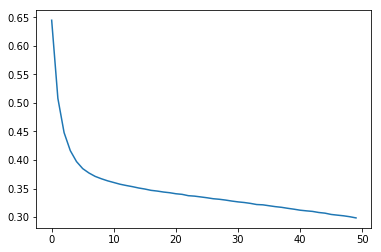

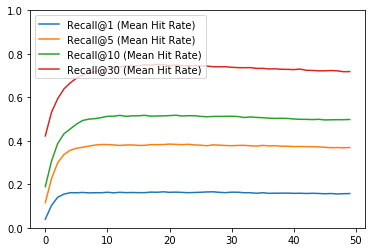

The time elapse of epoch 049 is: 00: 00: 35
Train loss 0.298660
Test recall@1: 0.157
Test recall@5: 0.369
Test recall@10: 0.498
Test recall@30: 0.718
Best recall@1 = 0.166 (epoch 19)
Best recall@5 = 0.385 (epoch 20)
Best recall@10 = 0.518 (epoch 21)
Best recall@30 = 0.751 (epoch 18)


In [71]:
losses = []
recall = {k : [] for k in args["top_k"]} # recall = mean test hit rate

for epoch in range(args["n_epochs"]):
    model.train() # Enable dropout (if have).
    start_time = time.time()
    train_loader.dataset.ng_sample()
    epoch_losses = []
    for user, item, item_ft, label in tqdm(train_loader):
        user = user.long().to(device)
        item = item.long().to(device)
        item_ft = item_ft.float().to(device)
        label = label.float().to(device)

        model.zero_grad()
        prediction = model(user, item, item_ft)
        loss = loss_function(prediction, label)
        loss.backward()
        opt.step()
        epoch_losses.append(loss.item())   
    losses.append(np.mean(epoch_losses))
    
    model.eval()
    mean_rec = evaluate(model, test_loader, args["top_k"])
    for k in args["top_k"]:
        recall[k].append(mean_rec[k])
    
    clear_output(True)
    plt.plot(losses)
    plt.show()
    for k in args["top_k"]:
        plt.plot(recall[k], label="Recall@{} (Mean Hit Rate)".format(k))
    plt.ylim(0., 1.)
    plt.legend()
    plt.show()
    elapsed_time = time.time() - start_time
    print("The time elapse of epoch {:03d}".format(epoch) + " is: " + 
            time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
    print("Train loss {:03f}".format(losses[-1]))
    for k in args["top_k"]:
        print("Test recall@{}: {:.3f}".format(k, recall[k][-1]))

for k in args["top_k"]:
    best_epoch = np.argmax(recall[k])
    best_rec = recall[k][best_epoch]
    print("Best recall@{} = {:.3f} (epoch {})".format(k, best_rec, best_epoch))

In [110]:
## пытаемся посмотреть на рекомендации 

def get_recommends(model, u):
    # get and draw last 15 bought items
    print("Purchased items:")
    bought = ratings_df.loc[ratings_df.reviewerID == u].sort_values("unixReviewTime")["asin"].values[-15:]
    plt.figure(figsize=(10, 7))
    for k, asin_bought in enumerate(bought):
        plt.subplot(3, 5, k + 1)
        plt.imshow(amazon_imgs.imgs[asin_bought][0])
    #     plt.xlabel(np.round(dist_i[j] * 1e+7, 3))
        plt.axis('off')
    plt.show()
    
    # predict by model and draw 15 more items for the user
    u_id = user_enc.transform([u])[0]
    u_te_idx = ratings_test.loc[ratings_test.reviewerID == u_id, "asin"].index[0]

    true_i = ratings_test.loc[ratings_test.reviewerID == u_id, "asin"].values
    neg_i = neg_test.loc[u_te_idx].values.ravel()
    sample_i = np.concatenate((true_i, neg_i))

    user = torch.LongTensor([u_id for i in sample_i])
    item = torch.LongTensor([i for i in sample_i])
    item_ft = torch.stack([torch.from_numpy(item_features[i]) for i in sample_i], dim=0).float()
    user.size(), item.size(), item_ft.size()

    with torch.no_grad():
        predictions = model(user.to(device), item.to(device), item_ft.to(device))
        _, indices = torch.topk(predictions, k=15)
        recommends = torch.take(item.to(device), indices).cpu().numpy().tolist()
        
    print("Recommended items:")
    plt.figure(figsize=(10, 7))
    for k, asin_rec in enumerate(item_enc.inverse_transform(recommends)):
        plt.subplot(3, 5, k + 1)
        plt.imshow(amazon_imgs.imgs[asin_rec][0])
    #     plt.xlabel(np.round(dist_i[j] * 1e+7, 3))
        plt.axis('off')
    plt.show()

In [77]:
ratings_df.loc[ratings_df.reviewerID.isin(users_test), "reviewerID"].value_counts()

A2GP4EJIAA2OE0    35
AVU1ILDDYW301     32
A2S696CI415O20    30
A3OXB8POGTLMFY    29
ATV3Q7KAY1KA5     22
A1JKEGU4RK1SLZ    21
A1E093ASOQ3DBF    21
A2QDOJFFLFGF18    20
A1QBOC76MIOJYP    19
A2OCDK0BOW6UCY    19
A2L20SNQ4EZJ8B    19
A26X9I00NCMT2W    19
A3EAHKRQIYNUYT    18
A3AARSXGKKGGVL    18
A2W9I628I6SE1U    18
A1F7YU6O5RU432    18
A12FPCFRA4Y1CO    18
A1RBEJ5UQ1RWAW    17
ADEOYOY6I8GW3     17
ABQWMANK4AR63     16
A2GSV7SJT3Y6RU    16
A1S9N94L3V34PH    16
A100WO06OQR8BQ    16
A1EY3NJP0WH3JQ    16
A3TXM86U72PBXE    16
A2B5608Y1QTOVB    16
A2KOV8XWZOZ0FQ    15
A2WC9NFLG57W4H    15
A1JMKPA2U1X8LV    15
A1DOWBCKQZPW9F    15
                  ..
A2GX8SJ28S6XCT     5
A3MBSM8VKO8NOY     5
AL6ILUZLMOFRI      5
A1DQYPYI53ABM      5
AS6VPQRYUEO3H      5
AJEDH6U3VE5AM      5
A23UH2RDVRXB1U     5
A2V5M5EJPOD2IU     5
A2064RG3BZICOP     5
A39LEJSTJ27RAM     5
A21K6XFU6MXDC2     5
A2ET041T5RG20N     5
A23Y18MH2SD1B6     5
A2JQXTQXK6VVND     5
A2SZVF9K3KCS71     5
A34UP6JUJZL0B1     5
AN9J46667D80O

Purchased items:


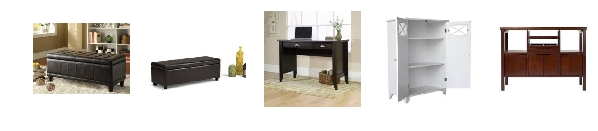

Recommended items:


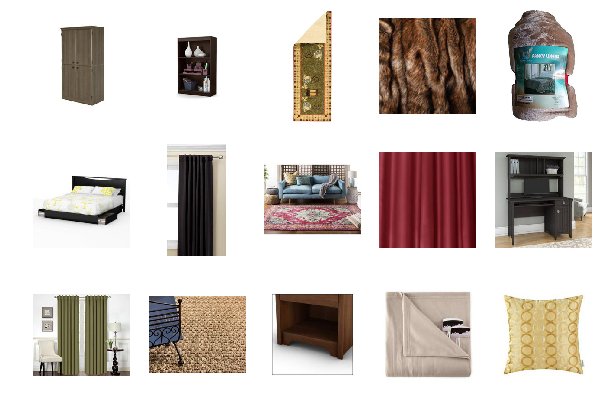

In [111]:
get_recommends(model, 'AS6VPQRYUEO3H')

Purchased items:


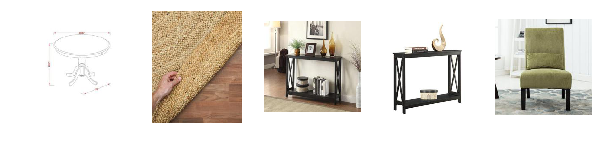

Recommended items:


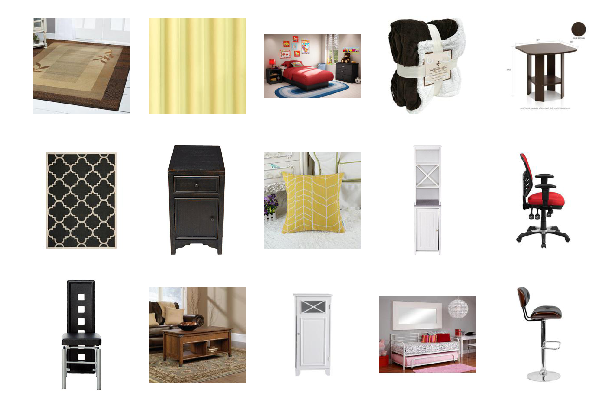

In [124]:
get_recommends(model, 'A3FY9W0R8G47BR')

Purchased items:


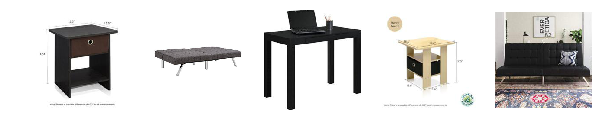

Recommended items:


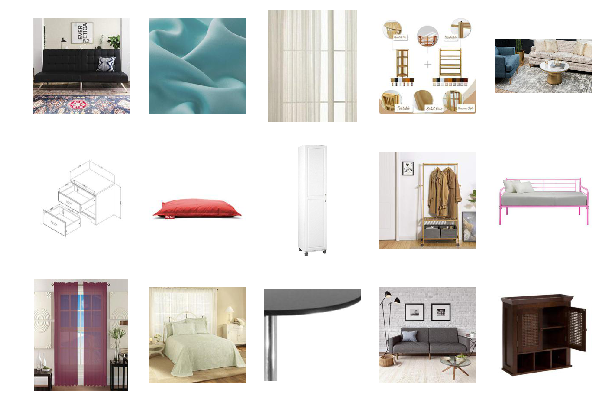

In [121]:
get_recommends(model, 'A13JCEF6B5DJAO')

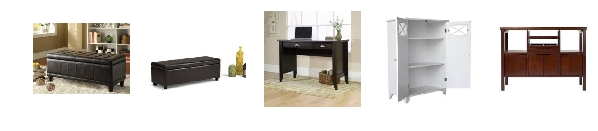

In [106]:
bought = ratings_df.loc[ratings_df.reviewerID == u].sort_values("unixReviewTime")["asin"].values[-15:]

plt.figure(figsize=(10, 7))
for k, asin_bought in enumerate(bought):
    plt.subplot(3, 5, k + 1)
    plt.imshow(amazon_imgs.imgs[asin_bought][0])
#     plt.xlabel(np.round(dist_i[j] * 1e+7, 3))
    plt.axis('off')
plt.show()

In [77]:
ratings_train.reviewerID.unique().shape, ratings_test.reviewerID.unique().shape

((74295,), (4428,))

In [78]:
# USER-ITEM matrix
args = {k : v for k, v in general_args.items()}
args.update({
    # training
    "n_epochs" : 50,
    "batch_size" : 1000,
    "lr" : 1e-4,
    # model
    "GMF_embedding_size" : 32,
    "MLP_embedding_size" : 128,
    "MLP_layers" : [128, 64, 32],
    "context_mode" : "none", 
    "dropout" : 0,
    "item_features_size" : len(item_features[0]),
    "item_preembed_size" : None,
    "mode" : "NeuMF-end",
})

model = NCF(args["user_num"], 
            args["item_num"], 
            args["GMF_embedding_size"], 
            args["MLP_embedding_size"], 
            args["item_features_size"], 
            args["item_preembed_size"], 
            args["MLP_layers"], 
            args["dropout"], 
            args["context_mode"],
            args["mode"], 
            GMF_model=None, MLP_model=None)
model.to(device)
loss_function = nn.BCEWithLogitsLoss()

if args["mode"] == 'NeuMF-pre':
    opt = torch.optim.SGD(model.parameters(), lr=args["lr"])
else:
    opt = torch.optim.Adam(model.parameters(), lr=args["lr"])

In [79]:
args

{'GMF_embedding_size': 32,
 'MLP_embedding_size': 128,
 'MLP_layers': [128, 64, 32],
 'batch_size': 1000,
 'context_mode': 'none',
 'dropout': 0,
 'item_features_size': 16,
 'item_num': 8245,
 'item_preembed_size': None,
 'lr': 0.0001,
 'mode': 'NeuMF-end',
 'n_epochs': 50,
 'num_ng': 4,
 'test_num_ng': 99,
 'top_k': [1, 5, 10, 30],
 'user_num': 130776}

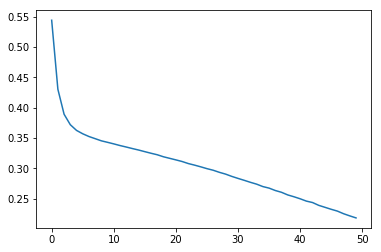

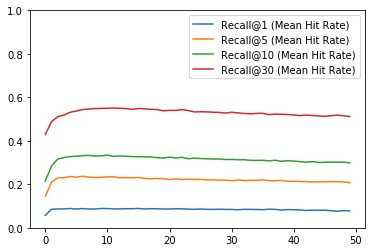

The time elapse of epoch 049 is: 00: 00: 37
Train loss 0.218097
Test recall@1: 0.078
Test recall@5: 0.208
Test recall@10: 0.298
Test recall@30: 0.512
Best recall@1 = 0.089 (epoch 15)
Best recall@5 = 0.237 (epoch 6)
Best recall@10 = 0.334 (epoch 10)
Best recall@30 = 0.551 (epoch 11)


In [80]:
losses = []
recall = {k : [] for k in args["top_k"]} # recall = mean test hit rate

for epoch in range(args["n_epochs"]):
    model.train() # Enable dropout (if have).
    start_time = time.time()
    train_loader.dataset.ng_sample()
    epoch_losses = []
    for user, item, item_ft, label in tqdm(train_loader):
        user = user.long().to(device)
        item = item.long().to(device)
        item_ft = item_ft.float().to(device)
        label = label.float().to(device)

        model.zero_grad()
        prediction = model(user, item, item_ft)
        loss = loss_function(prediction, label)
        loss.backward()
        opt.step()
        epoch_losses.append(loss.item())   
    losses.append(np.mean(epoch_losses))
    
    model.eval()
    mean_rec = evaluate(model, test_loader, args["top_k"])
    for k in args["top_k"]:
        recall[k].append(mean_rec[k])
    
    clear_output(True)
    plt.plot(losses)
    plt.show()
    for k in args["top_k"]:
        plt.plot(recall[k], label="Recall@{} (Mean Hit Rate)".format(k))
    plt.ylim(0., 1.)
    plt.legend()
    plt.show()
    elapsed_time = time.time() - start_time
    print("The time elapse of epoch {:03d}".format(epoch) + " is: " + 
            time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
    print("Train loss {:03f}".format(losses[-1]))
    for k in args["top_k"]:
        print("Test recall@{}: {:.3f}".format(k, recall[k][-1]))

for k in args["top_k"]:
    best_epoch = np.argmax(recall[k])
    best_rec = recall[k][best_epoch]
    print("Best recall@{} = {:.3f} (epoch {})".format(k, best_rec, best_epoch))

In [ ]:
# 2) USER-ITEM and product CATEGORIES

In [114]:
# USER-ITEM matrix
args = {k : v for k, v in general_args.items()}
args.update({
    # training
    "n_epochs" : 50,
    "batch_size" : 1000,
    "lr" : 5e-5,
    # model
    "GMF_embedding_size" : 32,
    "MLP_embedding_size" : 128,
    "MLP_layers" : [128, 64, 32],
    "context_mode" : "add", 
    "dropout" : 0,
    "item_features_size" : len(item_features[0]),
    "item_preembed_size" : None,
    "mode" : "NeuMF-end",
})

model_cat = NCF(args["user_num"], 
            args["item_num"], 
            args["GMF_embedding_size"], 
            args["MLP_embedding_size"], 
            args["item_features_size"], 
            args["item_preembed_size"], 
            args["MLP_layers"], 
            args["dropout"], 
            args["context_mode"],
            args["mode"], 
            GMF_model=None, MLP_model=None)
model_cat.to(device)
loss_function = nn.BCEWithLogitsLoss()

if args["mode"] == 'NeuMF-pre':
    opt = torch.optim.SGD(model_cat.parameters(), lr=args["lr"])
else:
    opt = torch.optim.Adam(model_cat.parameters(), lr=args["lr"])

In [115]:
args

{'GMF_embedding_size': 32,
 'MLP_embedding_size': 128,
 'MLP_layers': [128, 64, 32],
 'batch_size': 1000,
 'context_mode': 'add',
 'dropout': 0,
 'item_features_size': 16,
 'item_num': 8245,
 'item_preembed_size': None,
 'lr': 5e-05,
 'mode': 'NeuMF-end',
 'n_epochs': 50,
 'num_ng': 4,
 'test_num_ng': 99,
 'top_k': [1, 5, 10, 30],
 'user_num': 74295}

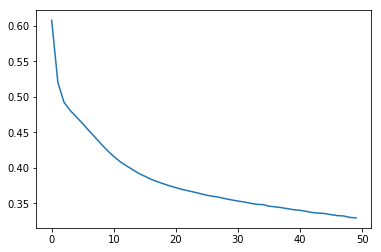

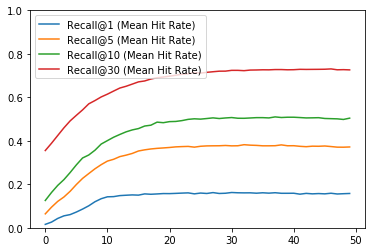

The time elapse of epoch 049 is: 00: 00: 37
Train loss 0.329378
Test recall@1: 0.158
Test recall@5: 0.372
Test recall@10: 0.504
Test recall@30: 0.726
Best recall@1 = 0.162 (epoch 30)
Best recall@5 = 0.382 (epoch 32)
Best recall@10 = 0.510 (epoch 37)
Best recall@30 = 0.731 (epoch 46)


In [116]:
losses = []
recall = {k : [] for k in args["top_k"]} # recall = mean test hit rate

for epoch in range(args["n_epochs"]):
    model_cat.train() # Enable dropout (if have).
    start_time = time.time()
    train_loader.dataset.ng_sample()
    epoch_losses = []
    for user, item, item_ft, label in tqdm(train_loader):
        user = user.long().to(device)
        item = item.long().to(device)
        item_ft = item_ft.float().to(device)
        label = label.float().to(device)

        model_cat.zero_grad()
        prediction = model_cat(user, item, item_ft)
        loss = loss_function(prediction, label)
        loss.backward()
        opt.step()
        epoch_losses.append(loss.item())   
    losses.append(np.mean(epoch_losses))
    
    model_cat.eval()
    mean_rec = evaluate(model_cat, test_loader, args["top_k"])
    for k in args["top_k"]:
        recall[k].append(mean_rec[k])
    
    clear_output(True)
    plt.plot(losses)
    plt.show()
    for k in args["top_k"]:
        plt.plot(recall[k], label="Recall@{} (Mean Hit Rate)".format(k))
    plt.ylim(0., 1.)
    plt.legend()
    plt.show()
    elapsed_time = time.time() - start_time
    print("The time elapse of epoch {:03d}".format(epoch) + " is: " + 
            time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
    print("Train loss {:03f}".format(losses[-1]))
    for k in args["top_k"]:
        print("Test recall@{}: {:.3f}".format(k, recall[k][-1]))

for k in args["top_k"]:
    best_epoch = np.argmax(recall[k])
    best_rec = recall[k][best_epoch]
    print("Best recall@{} = {:.3f} (epoch {})".format(k, best_rec, best_epoch))

Purchased items:


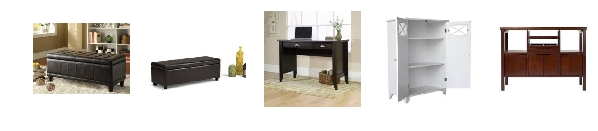

Recommended items:


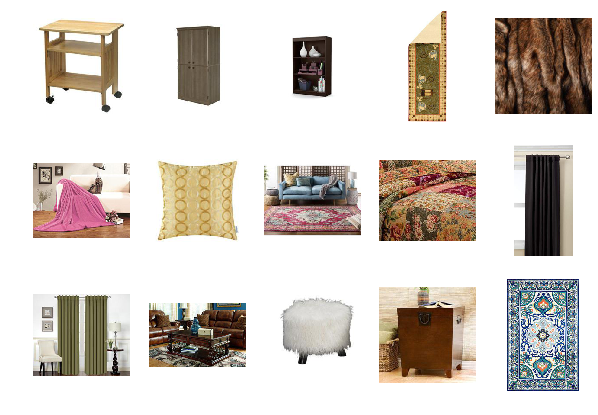

In [117]:
get_recommends(model_cat, 'AS6VPQRYUEO3H')

Purchased items:


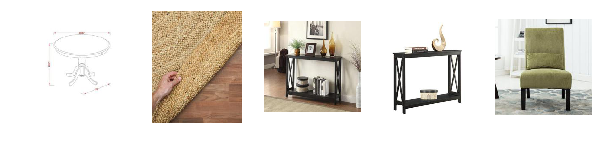

Recommended items:


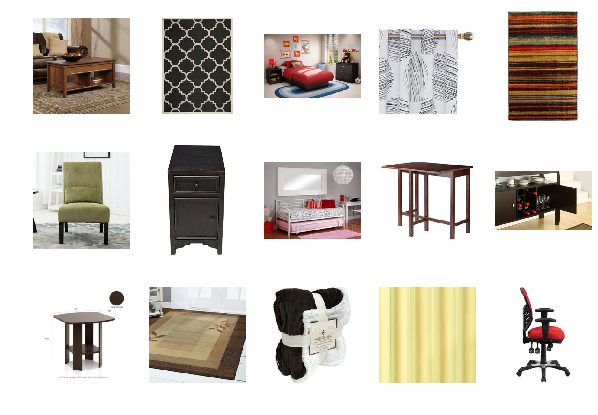

In [125]:
get_recommends(model_cat, 'A3FY9W0R8G47BR')

Purchased items:


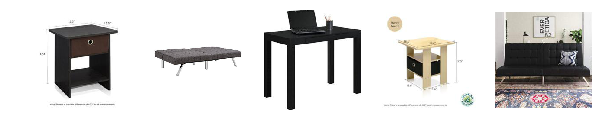

Recommended items:


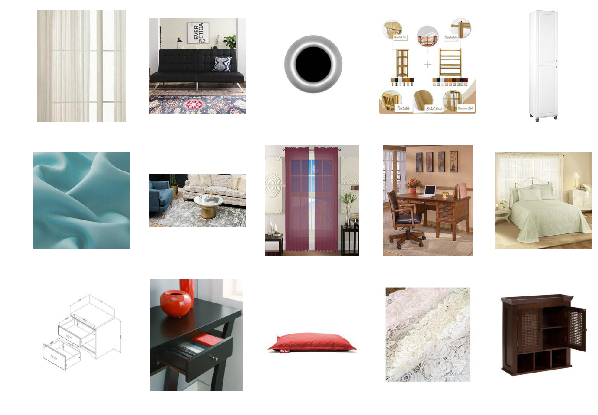

In [122]:
get_recommends(model_cat, 'A13JCEF6B5DJAO')

In [ ]:
# видим, что особо ничего не улучшилось

In [ ]:
# сетка, 
# использующая визуальные фичи для характеристики итемов
# (при этом визуальные фичи излекаются из обычной предобученной сети резнет)

In [53]:
import pickle
#  подгружаем эмбеддинги
with open('./clf_embeddings_1.pickle', 'rb') as handle:
    asin_embeddings_clf = pickle.load(handle)

In [54]:
asin2enc = {asin : i for i, asin in enumerate(item_enc.classes_)}
asin_embeddings_clf = {asin2enc[asin] : embs for asin, embs in tqdm(asin_embeddings_clf.items()) if asin in asin2enc}
len(asin_embeddings_clf)

100%|██████████| 8294/8294 [00:00<00:00, 579976.28it/s]


8245

In [104]:
# asin_embeddings_clf[0]

In [55]:
item_features[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [106]:
# 3.1) use ONLY embeddings
item_features = {}
for ix in items.index:
    item_features[ix] = np.float32(items.loc[ix].values)

# item_features = {item : torch.stack(asin_embeddings[item], dim=0).mean(dim=0).numpy() for item in tqdm(item_features)}
item_features = {item : asin_embeddings_clf[item][0].numpy() for item in tqdm(item_features)}
# item_features = {item : np.concatenate((
#     item_features[item],
#     asin_embeddings[item][0].numpy(),
# )) for item in tqdm(item_features)}

len(item_features), item_features[0].shape


100%|██████████| 8245/8245 [00:00<00:00, 296294.70it/s]

(8245, (256,))

In [116]:
train_dataset = NCFData(train_data, item_num, train_mat, args["num_ng"], True, item_features)
test_dataset = NCFData(test_data, item_num, train_mat, 0, False, item_features)
train_loader = data.DataLoader(train_dataset, batch_size=args["batch_size"], shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=args["test_num_ng"] + 1, shuffle=False)

In [117]:
# USER + ITEM embeddings
args = {k : v for k, v in general_args.items()}
args.update({
    # training
    "n_epochs" : 50,
    "batch_size" : 1000,
    "lr" : 3e-5,
    # model
    "GMF_embedding_size" : 32,
    "MLP_embedding_size" : 128,
    "MLP_layers" : [128, 64, 32],
    "context_mode" : "replace", 
    "dropout" : 0,
    "item_features_size" : len(item_features[0]),
    "item_preembed_size" : None,
    "mode" : "NeuMF-end",
})

model = NCF(args["user_num"], 
            args["item_num"], 
            args["GMF_embedding_size"], 
            args["MLP_embedding_size"], 
            args["item_features_size"], 
            args["item_preembed_size"], 
            args["MLP_layers"], 
            args["dropout"], 
            args["context_mode"],
            args["mode"], 
            GMF_model=None, MLP_model=None)
model.to(device)
loss_function = nn.BCEWithLogitsLoss()

if args["mode"] == 'NeuMF-pre':
    opt = torch.optim.SGD(model.parameters(), lr=args["lr"])
else:
    opt = torch.optim.Adam(model.parameters(), lr=args["lr"])

In [118]:
args

{'GMF_embedding_size': 32,
 'MLP_embedding_size': 128,
 'MLP_layers': [128, 64, 32],
 'batch_size': 1000,
 'context_mode': 'replace',
 'dropout': 0,
 'item_features_size': 256,
 'item_num': 8245,
 'item_preembed_size': None,
 'lr': 3e-05,
 'mode': 'NeuMF-end',
 'n_epochs': 50,
 'num_ng': 4,
 'test_num_ng': 99,
 'top_k': [1, 5, 10, 30],
 'user_num': 130776}

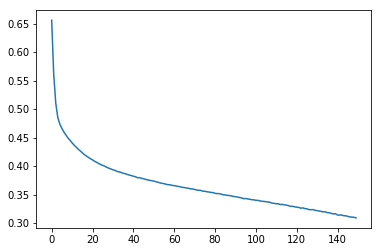

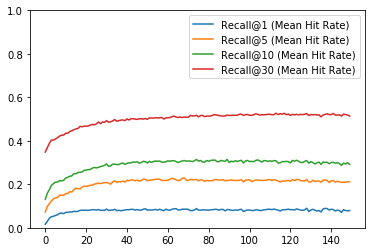

The time elapse of epoch 049 is: 00: 00: 59
Train loss 0.308977
Test recall@1: 0.079
Test recall@5: 0.211
Test recall@10: 0.292
Test recall@30: 0.513
Best recall@1 = 0.090 (epoch 128)
Best recall@5 = 0.229 (epoch 68)
Best recall@10 = 0.314 (epoch 74)
Best recall@30 = 0.527 (epoch 113)


In [121]:
# losses = []
# recall = {k : [] for k in args["top_k"]} # recall = mean test hit rate

for epoch in range(args["n_epochs"]):
    model.train() # Enable dropout (if have).
    start_time = time.time()
    train_loader.dataset.ng_sample()
    epoch_losses = []
    for user, item, item_ft, label in tqdm(train_loader):
        user = user.long().to(device)
        item = item.long().to(device)
        item_ft = item_ft.float().to(device)
        label = label.float().to(device)

        model.zero_grad()
        prediction = model(user, item, item_ft)
        loss = loss_function(prediction, label)
        loss.backward()
        opt.step()
        epoch_losses.append(loss.item())   
    losses.append(np.mean(epoch_losses))
    
    model.eval()
    mean_rec = evaluate(model, test_loader, args["top_k"])
    for k in args["top_k"]:
        recall[k].append(mean_rec[k])
    
    clear_output(True)
    plt.plot(losses)
    plt.show()
    for k in args["top_k"]:
        plt.plot(recall[k], label="Recall@{} (Mean Hit Rate)".format(k))
    plt.ylim(0., 1.)
    plt.legend()
    plt.show()
    elapsed_time = time.time() - start_time
    print("The time elapse of epoch {:03d}".format(epoch) + " is: " + 
            time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
    print("Train loss {:03f}".format(losses[-1]))
    for k in args["top_k"]:
        print("Test recall@{}: {:.3f}".format(k, recall[k][-1]))

for k in args["top_k"]:
    best_epoch = np.argmax(recall[k])
    best_rec = recall[k][best_epoch]
    print("Best recall@{} = {:.3f} (epoch {})".format(k, best_rec, best_epoch))

In [123]:
# USER + ITEM embeddings
args = {k : v for k, v in general_args.items()}
args.update({
    # training
    "n_epochs" : 50,
    "batch_size" : 1000,
    "lr" : 3e-5,
    # model
    "GMF_embedding_size" : 64,
    "MLP_embedding_size" : 256,
    "MLP_layers" : [256, 128, 64],
    "context_mode" : "replace", 
    "dropout" : 0,
    "item_features_size" : len(item_features[0]),
    "item_preembed_size" : None,
    "mode" : "NeuMF-end",
})

model = NCF(args["user_num"], 
            args["item_num"], 
            args["GMF_embedding_size"], 
            args["MLP_embedding_size"], 
            args["item_features_size"], 
            args["item_preembed_size"], 
            args["MLP_layers"], 
            args["dropout"], 
            args["context_mode"],
            args["mode"], 
            GMF_model=None, MLP_model=None)
model.to(device)
loss_function = nn.BCEWithLogitsLoss()

if args["mode"] == 'NeuMF-pre':
    opt = torch.optim.SGD(model.parameters(), lr=args["lr"])
else:
    opt = torch.optim.Adam(model.parameters(), lr=args["lr"])

In [124]:
args

{'GMF_embedding_size': 64,
 'MLP_embedding_size': 256,
 'MLP_layers': [256, 128, 64],
 'batch_size': 1000,
 'context_mode': 'replace',
 'dropout': 0,
 'item_features_size': 256,
 'item_num': 8245,
 'item_preembed_size': None,
 'lr': 3e-05,
 'mode': 'NeuMF-end',
 'n_epochs': 50,
 'num_ng': 4,
 'test_num_ng': 99,
 'top_k': [1, 5, 10, 30],
 'user_num': 130776}

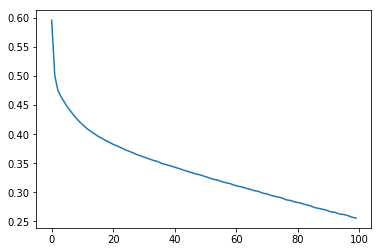

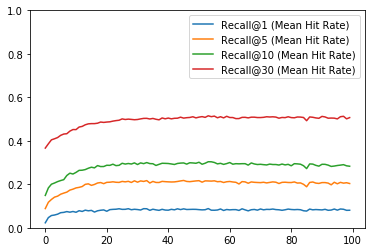

The time elapse of epoch 049 is: 00: 00: 51
Train loss 0.256037
Test recall@1: 0.081
Test recall@5: 0.204
Test recall@10: 0.283
Test recall@30: 0.507
Best recall@1 = 0.088 (epoch 53)
Best recall@5 = 0.218 (epoch 45)
Best recall@10 = 0.304 (epoch 53)
Best recall@30 = 0.515 (epoch 53)


In [127]:
# losses = []
# recall = {k : [] for k in args["top_k"]} # recall = mean test hit rate

for epoch in range(args["n_epochs"]):
    model.train() # Enable dropout (if have).
    start_time = time.time()
    train_loader.dataset.ng_sample()
    epoch_losses = []
    for user, item, item_ft, label in tqdm(train_loader):
        user = user.long().to(device)
        item = item.long().to(device)
        item_ft = item_ft.float().to(device)
        label = label.float().to(device)

        model.zero_grad()
        prediction = model(user, item, item_ft)
        loss = loss_function(prediction, label)
        loss.backward()
        opt.step()
        epoch_losses.append(loss.item())   
    losses.append(np.mean(epoch_losses))
    
    model.eval()
    mean_rec = evaluate(model, test_loader, args["top_k"])
    for k in args["top_k"]:
        recall[k].append(mean_rec[k])
    
    clear_output(True)
    plt.plot(losses)
    plt.show()
    for k in args["top_k"]:
        plt.plot(recall[k], label="Recall@{} (Mean Hit Rate)".format(k))
    plt.ylim(0., 1.)
    plt.legend()
    plt.show()
    elapsed_time = time.time() - start_time
    print("The time elapse of epoch {:03d}".format(epoch) + " is: " + 
            time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
    print("Train loss {:03f}".format(losses[-1]))
    for k in args["top_k"]:
        print("Test recall@{}: {:.3f}".format(k, recall[k][-1]))

for k in args["top_k"]:
    best_epoch = np.argmax(recall[k])
    best_rec = recall[k][best_epoch]
    print("Best recall@{} = {:.3f} (epoch {})".format(k, best_rec, best_epoch))

In [56]:
# 3.2) use ITEM embeddings + product cat
item_features = {}
for ix in items.index:
    item_features[ix] = np.float32(items.loc[ix].values)

# item_features = {item : torch.stack(asin_embeddings[item], dim=0).mean(dim=0).numpy() for item in tqdm(item_features)}
# item_features = {item : asin_embeddings_clf[item][0].numpy() for item in tqdm(item_features)}
item_features = {item : np.concatenate((
    item_features[item],
    asin_embeddings_clf[item][0].numpy(),
)) for item in tqdm(item_features)}

len(item_features), item_features[0].shape

100%|██████████| 8245/8245 [00:00<00:00, 198598.96it/s]


(8245, (272,))

In [57]:
train_dataset = NCFData(train_data, item_num, train_mat, args["num_ng"], True, item_features)
test_dataset = NCFData(test_data, item_num, train_mat, 0, False, item_features)
train_loader = data.DataLoader(train_dataset, batch_size=args["batch_size"], shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=args["test_num_ng"] + 1, shuffle=False)

In [58]:
# USER + ITEM embeddings + CAT
args = {k : v for k, v in general_args.items()}
args.update({
    # training
    "n_epochs" : 100,
    "batch_size" : 1000,
    "lr" : 5e-5,
    # model
    "GMF_embedding_size" : 32,
    "MLP_embedding_size" : 128,
    "MLP_layers" : [128, 64, 32],
    "context_mode" : "replace", 
    "dropout" : 0,
    "item_features_size" : len(item_features[0]),
    "item_preembed_size" : None,
    "mode" : "NeuMF-end",
})

model = NCF(args["user_num"], 
            args["item_num"], 
            args["GMF_embedding_size"], 
            args["MLP_embedding_size"], 
            args["item_features_size"], 
            args["item_preembed_size"], 
            args["MLP_layers"], 
            args["dropout"], 
            args["context_mode"],
            args["mode"], 
            GMF_model=None, MLP_model=None)
model.to(device)
loss_function = nn.BCEWithLogitsLoss()

if args["mode"] == 'NeuMF-pre':
    opt = torch.optim.SGD(model.parameters(), lr=args["lr"])
else:
    opt = torch.optim.Adam(model.parameters(), lr=args["lr"])

In [59]:
args

{'GMF_embedding_size': 32,
 'MLP_embedding_size': 128,
 'MLP_layers': [128, 64, 32],
 'batch_size': 1000,
 'context_mode': 'replace',
 'dropout': 0,
 'item_features_size': 272,
 'item_num': 8245,
 'item_preembed_size': None,
 'lr': 5e-05,
 'mode': 'NeuMF-end',
 'n_epochs': 100,
 'num_ng': 4,
 'test_num_ng': 99,
 'top_k': [1, 5, 10, 30],
 'user_num': 74295}

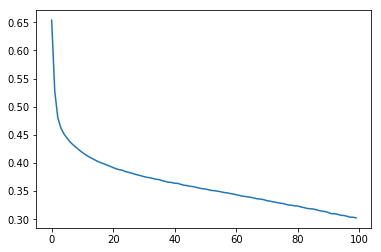

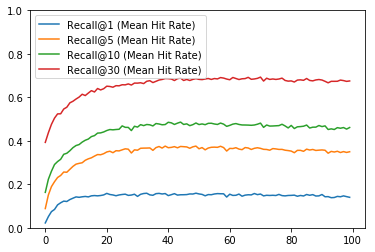

The time elapse of epoch 099 is: 00: 00: 45
Train loss 0.302278
Test recall@1: 0.140
Test recall@5: 0.350
Test recall@10: 0.461
Test recall@30: 0.675
Best recall@1 = 0.159 (epoch 49)
Best recall@5 = 0.376 (epoch 39)
Best recall@10 = 0.486 (epoch 44)
Best recall@30 = 0.693 (epoch 70)


In [60]:
losses = []
recall = {k : [] for k in args["top_k"]} # recall = mean test hit rate

for epoch in range(args["n_epochs"]):
    model.train() # Enable dropout (if have).
    start_time = time.time()
    train_loader.dataset.ng_sample()
    epoch_losses = []
    for user, item, item_ft, label in tqdm(train_loader):
        user = user.long().to(device)
        item = item.long().to(device)
        item_ft = item_ft.float().to(device)
        label = label.float().to(device)

        model.zero_grad()
        prediction = model(user, item, item_ft)
        loss = loss_function(prediction, label)
        loss.backward()
        opt.step()
        epoch_losses.append(loss.item())   
    losses.append(np.mean(epoch_losses))
    
    model.eval()
    mean_rec = evaluate(model, test_loader, args["top_k"])
    for k in args["top_k"]:
        recall[k].append(mean_rec[k])
    
    clear_output(True)
    plt.plot(losses)
    plt.show()
    for k in args["top_k"]:
        plt.plot(recall[k], label="Recall@{} (Mean Hit Rate)".format(k))
    plt.ylim(0., 1.)
    plt.legend()
    plt.show()
    elapsed_time = time.time() - start_time
    print("The time elapse of epoch {:03d}".format(epoch) + " is: " + 
            time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
    print("Train loss {:03f}".format(losses[-1]))
    for k in args["top_k"]:
        print("Test recall@{}: {:.3f}".format(k, recall[k][-1]))

for k in args["top_k"]:
    best_epoch = np.argmax(recall[k])
    best_rec = recall[k][best_epoch]
    print("Best recall@{} = {:.3f} (epoch {})".format(k, best_rec, best_epoch))

In [ ]:
# mb a couple more experiments 
# and embeddings from siamese network